In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('df_2.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low


НАБЛЮДЕНИЕ_1: В период Surge видим более низкую price-to-order конверсию

ГИПОТЕЗА: Если убрать надпись "повышенный спрос" то конверсия в заказ в период сурджа увеличится на 10пп.

In [3]:
#выбираем пользователей, которые делали заказ в период сурджа
df_surge = df.query("surge == 'surge'")
df_surge.head()

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
9,662775,17,Android,comfort,surge,1,1,1,1,0,1,4.828326,36,low
10,464055,20,iOS,comfort,surge,1,1,1,1,0,0,3.647097,25,high
18,393096,23,Android,comfort,surge,1,1,0,0,0,1,2.523357,19,high
21,103860,13,iOS,economy,surge,1,1,1,1,0,1,7.934002,21,high
24,461185,21,iOS,economy,surge,1,1,1,1,0,1,1.590209,29,high


In [5]:
#находим конверсию в заказ
df_surge['price_to_order_conv'] = round(df_surge.order_made / df_surge.price_seen,2) * 100

#находим среднюю конверсию относительно юзера (чтобы не было повторных вхождений юзера в выборки)
df_surge_by_user = df_surge.groupby('user_id', as_index=False).agg({'price_to_order_conv': 'mean'})


df_surge_by_user['group'] = np.random.randint(2, size=len(df_surge_by_user['price_to_order_conv'])) #колонка с рандом знач
df_surge_by_user.group.value_counts()
df_surge_by_user.head()

<ipython-input-5-a058ad3cc796>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surge['price_to_order_conv'] = round(df_surge.order_made / df_surge.price_seen,2) * 100


,user_id,price_to_order_conv,group
0,100093,50.0,1
1,100118,100.0,1
2,100134,100.0,0
3,100166,100.0,1
4,100255,0.0,0


In [7]:
#разбили датафрейм по группам 0-контрольная, 1-тестовая
group_0 = df_surge_by_user.query("group == 0")
group_1 = df_surge_by_user.query("group == 1")

In [8]:
print('кол-во наблюдений в group_0 =', len(group_0))
print('кол-во наблюдений в group_1 =', len(group_1))
print('общее кол-во наблюдений =', len(group_1) + len(group_0)) #проверка что никто не потерялся
print('средняя поюзерная конверсия (контрольная группа) =', round(group_0.price_to_order_conv.mean(),2))

print('средняя поюзерная конверсия (тестовая группа) =', round(group_1.price_to_order_conv.mean(),2))

кол-во наблюдений в group_0 = 8916
кол-во наблюдений в group_1 = 8864
общее кол-во наблюдений = 17780
средняя поюзерная конверсия (контрольная группа) = 72.61
средняя поюзерная конверсия (тестовая группа) = 72.09


УСЛОВИЯ

H_0: средние конверсии в 2х группах одинаковые

H_1: средние конверсии в 2х группах различны


p-value > alpha: принимаем H_0

p-value < alpha: отклоняем H_0


In [9]:
#t-тест средних конверсий
alpha = 0.05
ttest_ind(group_0['price_to_order_conv'], group_1['price_to_order_conv'])

Ttest_indResult(statistic=0.9276197614651656, pvalue=0.3536174364490656)

In [10]:
t = ttest_ind(group_0['price_to_order_conv'], group_1['price_to_order_conv'])
if t.pvalue > alpha:
  print(f'p-value {round(t.pvalue, 2)} > alpha {round(alpha, 2)}\nПринимаем H_0 - средние выборок равны.\nГруппы равномерные и их можно использовать для дальнейшего a/b теста ')
else:
  print(f'p-value {round(t.pvalue, 2)} < alpha {round(alpha, 2)}\nОтклоняем H_0 - средние выборок не равны\nГруппы не равномерные. Необходимо пересмотреть разделение на группы')

p-value 0.35 > alpha 0.05
Принимаем H_0 - средние выборок равны.
Группы равномерные и их можно использовать для дальнейшего a/b теста 


**Пробуем провести бутстрап для групп group_0 и group_1**

(array([ 2.,  1.,  7., 10., 16., 22., 22., 10.,  8.,  2.]),
 array([-1.98229874, -1.71632692, -1.4503551 , -1.18438328, -0.91841146,
        -0.65243964, -0.38646782, -0.120496  ,  0.14547582,  0.41144764,
         0.67741946]),
 <a list of 10 Patch objects>)

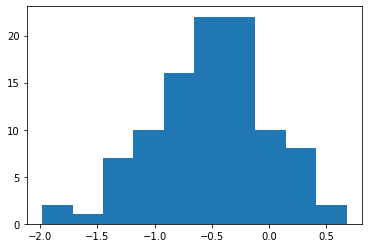

In [11]:
p_diffs = []
for i in range(100):
    sample_new_mean = group_1.sample(frac=1, replace=True)['price_to_order_conv'].mean()
    sample_old_mean = group_0.sample(frac=1, replace=True)['price_to_order_conv'].mean()
    p_diffs.append(sample_new_mean - sample_old_mean)
plt.hist(p_diffs)

In [12]:
#переводим list p_diffs в df

p_diffs=pd.DataFrame(p_diffs)
p_diffs.columns=['mean_of_metric']

**Расчет границ доверительного интервала**

In [13]:
alpha = 0.05 #уровень значимости (вероятность ошибочно отклонить H_0)
A = round(p_diffs['mean_of_metric'].quantile(alpha/2),3) #левая граница
B = round(p_diffs['mean_of_metric'].quantile(1-alpha/2),3) #правая граница
print('Граница доверительного интервала:',A,B)

Граница доверительного интервала: -1.499 0.291


In [14]:
if A < 0 < B:
  print(f'"0" находится внутри интервала [{A} ; {B}]. \nПринимаем H_0 - средние выборок равны.\nГруппы равномерные и их можно использовать для дальнейшего a/b теста')
else:
  print(f'0 находится за границей интервала [{A} ; {B}]. \nОтвергаем H_0 - средние выборок неравны.\nГруппы не равномерные. Необходимо пересмотреть разделение на группы')

"0" находится внутри интервала [-1.499 ; 0.291]. 
Принимаем H_0 - средние выборок равны.
Группы равномерные и их можно использовать для дальнейшего a/b теста


НАБЛЮДЕНИЕ_2: Если Comfort & Business классы, то более низкие юзерские отмены, более длинные поездки

ГИПОТЕЗА: Если понизить стоимость поездки на бизнес класс на 5%, то средняя дистанция уменьшится (т.е. пользователи будут чаще выбирать бизнес и на более короткие поездки)

In [15]:
#длина поездки в разбивке по классам
df.groupby('order_class',as_index=False).agg({'distance':'mean'})

,order_class,distance
0,business,12.013842
1,comfort,5.025267
2,economy,3.997445


In [16]:
df_business = df.query("order_class == 'business' and order_made == 1")
df_business.head()

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low
22,667749,5,Android,business,no surge,1,1,1,0,1,1,5.612632,23,low
40,449906,9,iOS,business,no surge,1,1,1,1,0,1,12.089362,22,high
45,683124,11,iOS,business,surge,1,1,1,1,0,1,15.155294,20,high


In [18]:
#находим средюю дистанцию для каждого юзера

df_business = df_business.groupby('user_id', as_index=False) \
                        .agg({'distance': 'mean'}) \
                        .rename(columns={'distance':'distance_mean'}) \
                        .fillna(0) #заполнили нулями пустые ячейки в distance 
                                   #по идее их не должно быть если user_canceled == 0 )
                

df_business['group'] = np.random.randint(2, size=len(df_business['distance_mean'])) #колонка с рандом знач
df_business.group.value_counts()
df_business.head()

,user_id,distance_mean,group
0,100134,13.714453,0
1,100424,22.763366,1
2,100463,9.949819,1
3,100643,12.505037,0
4,100675,13.270409,0


In [19]:
group_business_0 = df_business.query("group == 0")
group_business_1 = df_business.query("group == 1")

In [20]:
print('кол-во наблюдений в group_business_0 =', len(group_business_0))
print('кол-во наблюдений в group_business_1 =', len(group_business_1))
print('средняя поюзерная дистанция (контрольная группа) =', round(group_business_0.distance_mean.mean(),2))

print('средняя поюзерная дистанция (тестовая группа) =', round(group_business_1.distance_mean.mean(),2))

кол-во наблюдений в group_business_0 = 3699
кол-во наблюдений в group_business_1 = 3612
средняя поюзерная дистанция (контрольная группа) = 12.01
средняя поюзерная дистанция (тестовая группа) = 12.12


In [21]:
#t-тест средних конверсий
alpha = 0.05
ttest_ind(group_business_0['distance_mean'], group_business_1['distance_mean'])

Ttest_indResult(statistic=-1.048767931505353, pvalue=0.29431961749190616)

In [22]:
t = ttest_ind(group_business_0['distance_mean'], group_business_1['distance_mean'])
if t.pvalue > alpha:
  print(f'p-value {round(t.pvalue, 2)} > alpha {round(alpha, 2)}\nПринимаем H_0 - средние выборок равны.\nГруппы равномерные и их можно использовать для дальнейшего a/b теста ')
else:
  print(f'p-value {round(t.pvalue, 2)} < alpha {round(alpha, 2)}\nОтклоняем H_0 - средние выборок не равны\nГруппы не равномерные. Необходимо пересмотреть разделение на группы')

p-value 0.29 > alpha 0.05
Принимаем H_0 - средние выборок равны.
Группы равномерные и их можно использовать для дальнейшего a/b теста 


**Пробуем провести бутстрап для групп group_business_0 и group_business_1**

(array([ 4.,  3., 10., 24., 14., 25., 12.,  3.,  4.,  1.]),
 array([-0.15464653, -0.09733053, -0.04001454,  0.01730146,  0.07461745,
         0.13193344,  0.18924944,  0.24656543,  0.30388143,  0.36119742,
         0.41851342]),
 <a list of 10 Patch objects>)

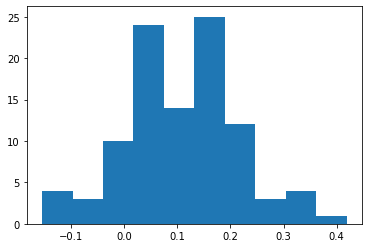

In [23]:
p_diffs = []
for i in range(100):
    sample_new_mean = group_business_1.sample(frac=1, replace=True)['distance_mean'].mean()
    sample_old_mean = group_business_0.sample(frac=1, replace=True)['distance_mean'].mean()
    p_diffs.append(sample_new_mean - sample_old_mean)
plt.hist(p_diffs)

In [24]:
p_diffs=pd.DataFrame(p_diffs)
p_diffs.columns=['mean_of_metric']

alpha = 0.05 #уровень значимости (вероятность ошибочно отклонить H_0)
A = round(p_diffs['mean_of_metric'].quantile(alpha/2),3) #левая граница
B = round(p_diffs['mean_of_metric'].quantile(1-alpha/2),3) #правая граница

if A < 0 < B:
  print(f'"0" находится внутри интервала [{A} ; {B}]. \nПринимаем H_0 - средние выборок равны.\nГруппы равномерные и их можно использовать для дальнейшего a/b теста')
else:
  print(f'0 находится за границей интервала [{A} ; {B}]. \nОтвергаем H_0 - средние выборок неравны.\nГруппы не равномерные. Необходимо пересмотреть разделение на группы')

"0" находится внутри интервала [-0.101 ; 0.33]. 
Принимаем H_0 - средние выборок равны.
Группы равномерные и их можно использовать для дальнейшего a/b теста
